In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install flax optax jetnet
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
import sys
from functools import partial
sys.path.append("../")

import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
import numpy as vnp
import tensorflow as tf
import numpy as vnp

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step

from jetnet.datasets import JetNet, TopTagging
from datasets import jetnet_dataset

%load_ext autoreload
%autoreload 2

## The `JetNet` data

In [3]:
train_ds, norm_dict = jetnet_dataset(n_features=3, n_particles=150, batch_size=64, seed=42, jet_type=["q","g"], condition_on_jet_features=True, std_particle=(1.0, 1.0, 5.0))

In [4]:
batches = create_input_iter(train_ds)

In [5]:
x, conditioning, mask = next(batches)

In [6]:
mean_particle, std_particle = norm_dict['mean_particle'], norm_dict['std_particle']

In [7]:
n_features = 3

particle_data = x * std_particle[..., :] + mean_particle[..., :]
particle_data = particle_data[0]
particle_data = vnp.ma.array(particle_data, mask=np.tile(~(mask[:, :, None] > 0), (1, 1, n_features)))
particle_data = particle_data.filled(fill_value=0.)

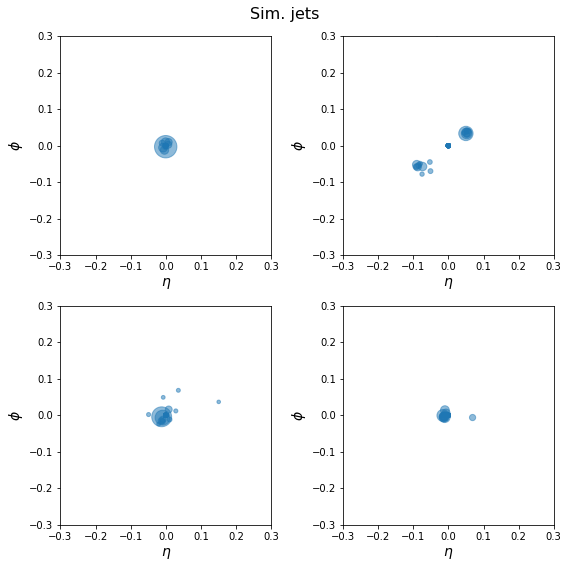

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    ax.scatter(*particle_data[i, :, :2].T, s=1000 * (particle_data[i, :, 2]), alpha=0.5)
    
    ax.set_xlabel(r"$\eta$", fontsize=14)
    ax.set_ylabel(r"$\phi$", fontsize=14)
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets", fontsize=16)
plt.tight_layout()

## Instantiate and train model

In [9]:
# score_dict = FrozenDict({"d_model":256, "d_mlp":512, "n_layers":4, "n_heads":2})  # Transformer args
# encoder_dict = decoder_dict = FrozenDict({})
# score = "transformer"

score_dict = FrozenDict({"k":10, "latent_size":128, "skip_connections":True, "num_mlp_layers":4, "message_passing_steps":4, "n_pos_features":2})  # GNN args
encoder_dict = decoder_dict = FrozenDict({})
score = "graph"

vdm = VariationalDiffusionModel(
          timesteps=0, 
          d_t_embedding=16,
          d_feature=3,
          score=score,
          score_dict=score_dict,
          n_classes=2,
          embed_context=True,
          d_context_embedding=32,
          noise_schedule="learned_linear",
          gamma_min=-8.,
          gamma_max=14.,
          use_encdec=False,
          encoder_dict=encoder_dict,
          decoder_dict=decoder_dict)

In [10]:
# Pass a test batch through to initialize model
n_smoke = 4

x = np.array(x[0, :n_smoke])
conditioning = np.array(conditioning[0, :n_smoke])
mask = np.array(mask[0, :n_smoke])

rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng}, x, conditioning, mask);

(150, 128)
(150, 128)
(150, 128)
(150, 128)


In [11]:
print(f"Params: {param_count(params):,}")

Params: 767,475


In [12]:
# Evaluate the loss for good measure
loss_vdm(params, vdm, rng, x, np.zeros_like(conditioning), mask)

(150, 128)
(150, 128)
(150, 128)
(150, 128)


Array(381.55844, dtype=float32)

In [ ]:
train_steps = 30_000

schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=3e-4, warmup_steps=1000, decay_steps=train_steps)
opt = optax.adamw(learning_rate=schedule, weight_decay=1e-4)

In [14]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4))
def train_step(state, batch, rng, model, loss_fn):
    """Train for a single step."""
    x, conditioning, mask = batch
    loss, grads = jax.value_and_grad(loss_fn)(state.params, model, rng, x, conditioning, mask)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics

In [15]:
from flax.training import train_state
        
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=opt)
pstate = replicate(state)

with trange(train_steps) as steps:
    for step in steps:

        rng, *train_step_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
        train_step_rng = np.asarray(train_step_rng)

        pstate, metrics = train_step(pstate, next(batches), train_step_rng, vdm, loss_vdm)
        steps.set_postfix(val=unreplicate(metrics["loss"]))

100%|█████████████████████| 30000/30000 [12:10<00:00, 41.08it/s, val=1.2699077]


## Conditional generation

For simplicity, let's just condition the model on random jet classes from the training set.

In [16]:
n_iter = 50

x_samples_list = []
x_list = []
for i in tqdm(range(n_iter)):
    x, conditioning, mask = next(batches)
    x, conditioning, mask = x[0], conditioning[0], mask[0]
    
    # Gen
    x_samples = generate(vdm, unreplicate(pstate).params, rng, (64, 150), conditioning, mask=mask, steps=100).mean()
    x_samples = x_samples * std_particle[..., :] + mean_particle[..., :]
    x_samples = vnp.ma.array(x_samples, mask=np.tile(~(mask[:, :, None] > 0), (1, 1, n_features)))
    x_samples = x_samples.filled(fill_value=0.)
    x_samples_list.append(x_samples)
    
    # Sim
    x = x * std_particle[..., :] + mean_particle[..., :]
    x = vnp.ma.array(x, mask=np.tile(~(mask[:, :, None] > 0), (1, 1, n_features)))
    x = x.filled(fill_value=0.)
    x_list.append(x)

100%|██████████████████████████████████████████| 50/50 [03:41<00:00,  4.44s/it]


In [17]:
from einops import rearrange
x_samples = rearrange(np.array(x_samples_list), "n b p f -> (n b) p f")
x = rearrange(np.array(x_list), "n b p f -> (n b) p f")

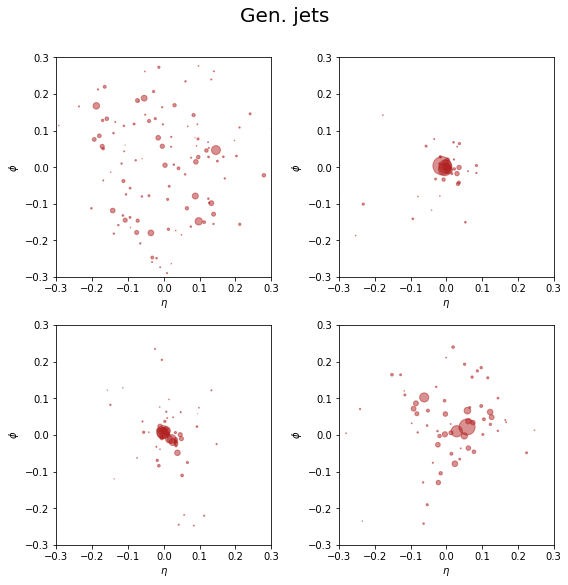

In [18]:
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * (x_samples[i, :, 2]), alpha=0.5, color="firebrick")
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

## Evaluate

Compare summaries between genreated and training samples.

In [19]:
import energyflow as ef

def jet_masses(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    masses = ef.ms_from_p4s(jets_p4s.sum(axis=1))
    return masses

def jet_ys(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    ys = ef.ys_from_p4s(jets_p4s.sum(axis=1))
    return ys

def jet_etas(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    etas = ef.etas_from_p4s(jets_p4s.sum(axis=1))
    return etas

def jet_phis(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    phis = ef.phis_from_p4s(jets_p4s.sum(axis=1), phi_ref=0)
    return phis

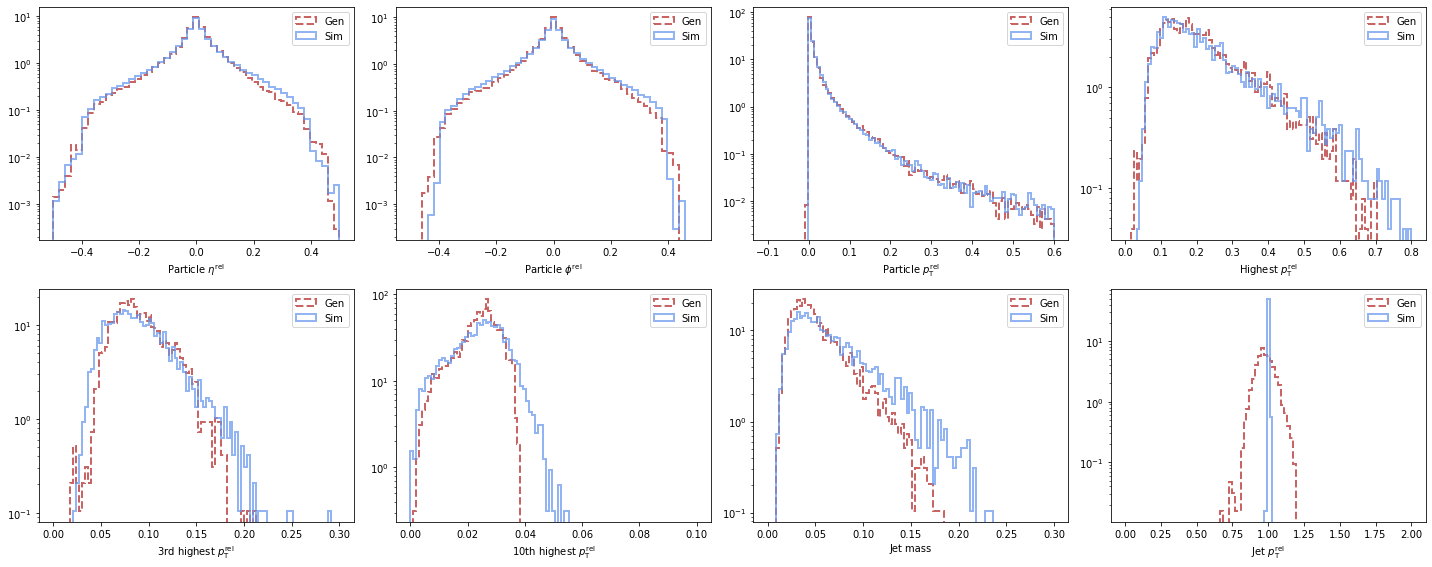

In [20]:
color_sim = "cornflowerblue"
color_gen = "firebrick"

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)

x_samples = vnp.array(x_samples)
x = vnp.array(x)

x_samples[x == 0.] = -999.
x[x == 0.] = -999.

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.concatenate(x_samples)[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = vnp.concatenate(np.array(x))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.concatenate(x_samples)[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = vnp.concatenate(vnp.array(x))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.6, 100)
ax.hist(vnp.concatenate(x_samples)[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = vnp.concatenate(np.array(x))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")
ax.legend()

x_samples[x == -999.] = 0.
x[x == -999.] = 0.

######

ax = fig.add_subplot(gs[3])

bins = vnp.linspace(0., 0.8, 100)
ax.hist(vnp.max(x_samples[:, :, 2], -1), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.max(x[:, :, 2], -1), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[4])

bins = vnp.linspace(0., 0.3, 100)
ax.hist(vnp.sort(x_samples[:, :, 2])[:, -3], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.sort(x[:, :, 2])[:, -3], histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"3rd highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[5])

bins = vnp.linspace(0., 0.1, 100)
ax.hist(vnp.sort(x_samples[:, :, 2])[:, -10], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.sort(x[:, :, 2])[:, -10], histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"10th highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[6])

bins= vnp.linspace(0., 0.3, 100)

jet_mass = jet_masses(vnp.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

jet_mass = jet_masses(vnp.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet mass")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[7])

bins= vnp.linspace(0., 2, 100)

ax.hist(vnp.abs(x_samples[:, :, 2]).sum(-1), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.abs(x[:, :, 2]).sum(-1), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()